<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/GAN/CGAN(2014).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference
- https://github.com/eriklindernoren/PyTorch-GAN

In [21]:
import torchvision.datasets as datasets
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import time
from torchvision.transforms.functional import to_pil_image
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터셋 불러오기

In [2]:
# 데이터 경로 지정
path2data = './data'
os.makedirs(path2data, exist_ok=True)

In [3]:
# Transformation 정의
train_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.5],[0.5]),
])

In [4]:
# MNIST dataset 불러오기
train_ds = datasets.MNIST(path2data, train=True, transform=train_transform, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


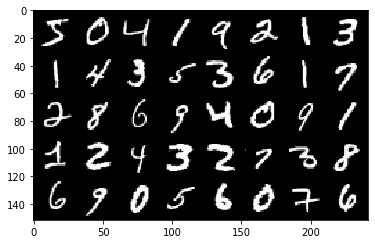

In [5]:
# 샘플 이미지 확인하기
img, label = train_ds.data, train_ds.targets

# 차원 추가
if len(img.shape) == 3:
    img = img.unsqueeze(1) # B*C*H*W

# 그리드 생성
img_grid = utils.make_grid(img[:40], nrow=8, padding=2)

def show(img):
    npimg = img.numpy()
    npimg_tr = npimg.transpose((1,2,0)) # [C,H,W] -> [H,W,C]
    plt.imshow(npimg_tr, interpolation='nearest')

show(img_grid)

In [6]:
# 데이터 로더 생성
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

# 모델 구축하기

In [7]:
# 파라미터 설정
params = {'num_classes':10,
          'nz':100,
          'input_size':(1,28,28)}

In [9]:
# Generator: 가짜 이미지를 생성합니다.
# noise와 label을 결합하여 학습합니다..

class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.num_classes = params['num_classes'] # 클래스 수, 10
        self.nz = params['nz'] # 노이즈 수, 100
        self.input_size = params['input_size'] # (1,28,28)

        # noise와 label을 결합할 용도인 label embedding matrix를 생성합니다.
        self.label_emb = nn.Embedding(self.num_classes, self.num_classes)

        self.gen = nn.Sequential(
            nn.Linear(self.nz + self.num_classes, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,int(np.prod(self.input_size))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # noise와 label 결합
        gen_input = torch.cat((self.label_emb(labels),noise),-1)
        x = self.gen(gen_input)
        x = x.view(x.size(0), *self.input_size)
        return x

# check
x = torch.randn(16,100,device=device) # 노이즈
label = torch.randint(0,10,(16,),device=device) # 레이블
model_gen = Generator(params).to(device)
out_gen = model_gen(x,label) # 가짜 이미지 생성
print(out_gen.shape)

torch.Size([16, 1, 28, 28])


In [12]:
# Discriminator: 가짜 이미지와 진짜 이미지를 식별합니다.
class Discriminator(nn.Module):
    def __init__(self,params):
        super().__init__()
        self.input_size = params['input_size']
        self.num_classes = params['num_classes']

        self.label_embedding = nn.Embedding(self.num_classes, self.num_classes)

        self.dis = nn.Sequential(
            nn.Linear(self.num_classes+int(np.prod(self.input_size)),512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # 이미지와 label 결합
        dis_input = torch.cat((img.view(img.size(0),-1),self.label_embedding(labels)),-1)

        x = self.dis(dis_input)
        return x

# check
x = torch.randn(16,1,28,28,device=device)
label = torch.randint(0,10,(16,), device=device)
model_dis = Discriminator(params).to(device)
out_dis = model_dis(x,label)
print(out_dis.shape)

torch.Size([16, 1])


In [13]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

# 학습하기

In [14]:
# 손실 함수
loss_func = nn.BCELoss()

from torch import optim

lr = 2e-4
beta1 = 0.5
beta2 = 0.999

# optimization
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1,beta2))

In [15]:
nz = params['nz']
num_epochs = 100

loss_history={'gen':[],
              'dis':[]}

In [24]:
# 학습
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.shape[0]

        xb = xb.to(device)
        yb = yb.to(device)
        yb_real = torch.Tensor(ba_si,1).fill_(1.0).to(device) # real_label
        yb_fake = torch.Tensor(ba_si,1).fill_(0.0).to(device) # fake_label

        # Genetator
        model_gen.zero_grad()
        noise = torch.randn(ba_si,100).to(device) # 노이즈 생성
        gen_label = torch.randint(0,10,(ba_si,)).to(device) # label 생성

        # 가짜 이미지 생성
        out_gen = model_gen(noise, gen_label)

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen, gen_label)

        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()

        # Discriminator
        model_dis.zero_grad()
        
        # 진짜 이미지 판별
        out_dis = model_dis(xb, yb)
        loss_real = loss_func(out_dis, yb_real)

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen.detach(),gen_label)
        loss_fake = loss_func(out_dis,yb_fake)

        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        opt_dis.step()

        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())

        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))

Epoch: 1, G_Loss: 2.200200, D_Loss: 0.321307, time: 0.27 min
Epoch: 2, G_Loss: 1.626625, D_Loss: 0.366446, time: 0.54 min
Epoch: 3, G_Loss: 1.645041, D_Loss: 0.553681, time: 0.81 min
Epoch: 4, G_Loss: 1.780483, D_Loss: 0.343987, time: 1.07 min
Epoch: 5, G_Loss: 2.582029, D_Loss: 0.272045, time: 1.33 min
Epoch: 6, G_Loss: 2.278525, D_Loss: 0.335163, time: 1.59 min
Epoch: 7, G_Loss: 1.813973, D_Loss: 0.385986, time: 1.85 min
Epoch: 8, G_Loss: 1.700746, D_Loss: 0.376636, time: 2.10 min
Epoch: 9, G_Loss: 3.243923, D_Loss: 0.250878, time: 2.36 min
Epoch: 10, G_Loss: 1.579337, D_Loss: 0.333616, time: 2.63 min
Epoch: 11, G_Loss: 2.865116, D_Loss: 0.188637, time: 2.90 min
Epoch: 12, G_Loss: 1.490703, D_Loss: 0.368529, time: 3.17 min
Epoch: 13, G_Loss: 2.551489, D_Loss: 0.319264, time: 3.44 min
Epoch: 14, G_Loss: 2.529016, D_Loss: 0.356711, time: 3.71 min
Epoch: 15, G_Loss: 2.194355, D_Loss: 0.439149, time: 3.98 min
Epoch: 17, G_Loss: 1.875876, D_Loss: 0.355893, time: 4.25 min
Epoch: 18, G_Loss

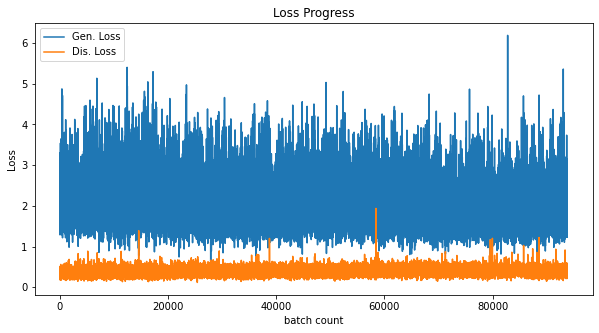

In [25]:
# plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# 가중치 저장
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

# Generator이 생성한 가짜 이미지 확인

In [27]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100, device=device)
    label = torch.randint(0,10,(16,), device=device)
    img_fake = model_gen(fixed_noise, label).detach().cpu()
print(img_fake.shape)

torch.Size([16, 1, 28, 28])


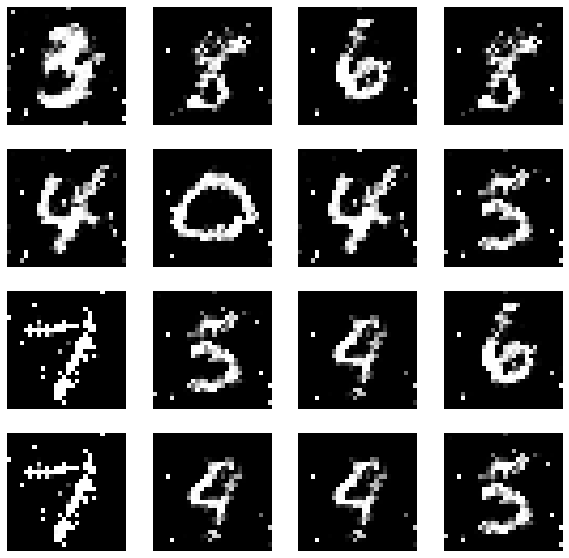

In [28]:
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5), cmap='gray')
    plt.axis('off')